In [71]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
from scipy import stats
from pandas.plotting import autocorrelation_plot

plt.rcParams['figure.facecolor'] = 'w'

In [2]:
def date_parser(x):
    if str.lower(x) == 'unknown':
        return None
    return datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')

df = pd.read_csv('../data/fullsample.csv',
                 parse_dates=['BEGIN', 'END'],
                 date_parser=date_parser)


In [3]:
df = df.rename(columns=str.lower)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395885 entries, 0 to 7395884
Data columns (total 12 columns):
 #   Column     Dtype         
---  ------     -----         
 0   jobid      object        
 1   state      object        
 2   begin      datetime64[ns]
 3   end        datetime64[ns]
 4   reqmem     object        
 5   usedmem    object        
 6   reqtime    object        
 7   usedtime   object        
 8   nodes      int64         
 9   cpus       int64         
 10  partition  object        
 11  exitcode   object        
dtypes: datetime64[ns](2), int64(2), object(8)
memory usage: 677.1+ MB


In [5]:
# add date and hour of day column
df['date_end'] = df['end'].dt.date
df['year_end'] = df['end'].dt.year
df['week_end'] = df['end'].dt.week
df['day_end'] = df['end'].dt.day
df['day_name'] = df['end'].dt.day_name().str[0:3].str.upper()
df['month_end'] = df['end'].dt.month
df['month_name'] = df['end'].dt.month_name()
df['hour_of_day_end'] = df['end'].dt.hour

df.info()

<ipython-input-5-6994bd6363e8>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week_end'] = df['end'].dt.week


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395885 entries, 0 to 7395884
Data columns (total 20 columns):
 #   Column           Dtype         
---  ------           -----         
 0   jobid            object        
 1   state            object        
 2   begin            datetime64[ns]
 3   end              datetime64[ns]
 4   reqmem           object        
 5   usedmem          object        
 6   reqtime          object        
 7   usedtime         object        
 8   nodes            int64         
 9   cpus             int64         
 10  partition        object        
 11  exitcode         object        
 12  date_end         object        
 13  year_end         float64       
 14  week_end         float64       
 15  day_end          float64       
 16  day_name         object        
 17  month_end        float64       
 18  month_name       object        
 19  hour_of_day_end  float64       
dtypes: datetime64[ns](2), float64(5), int64(2), object(11)
memory usage:

In [6]:
# count values per day per hour

jobs_ended = df\
    .value_counts(subset=['date_end',
                          'year_end',
                          'month_end',
                          'week_end',
                          'day_end',
                          'month_name',
                          'day_name',
                          'hour_of_day_end',
                          'exitcode'])\
    .reset_index()\
    .set_index(['date_end', 'year_end', 'month_end', 'week_end', 'hour_of_day_end'])\
    .rename(columns={0:'jobs_ended_per_hour'})


In [7]:
jobs_ended.head()

,,,,,day_end,month_name,day_name,exitcode,jobs_ended_per_hour
date_end,year_end,month_end,week_end,hour_of_day_end,,,,,
2020-12-11,2020.0,12.0,50.0,9.0,11.0,December,FRI,0:0,13346
2021-08-11,2021.0,8.0,32.0,16.0,11.0,August,WED,0:0,13046
2021-08-31,2021.0,8.0,35.0,16.0,31.0,August,TUE,0:0,12917
2021-09-01,2021.0,9.0,35.0,0.0,1.0,September,WED,0:0,12834
2021-09-13,2021.0,9.0,37.0,16.0,13.0,September,MON,0:0,12780


In [8]:
def draw_plot(series=None, kind='line', title='', xlabel='', ylabel=''):
    matplotlib.pyplot.ticklabel_format(axis='y', style='plain', useLocale=True)
    series.plot(kind=kind,
                title=title,
                xlabel=xlabel,
                ylabel=ylabel)

In [9]:
def print_outliers_msg(series=None, label='', size=5):
    top_5 = series.nlargest(n=size).sort_values()
    bottom_5 = series.nsmallest(n=size).sort_values()

    print(f'The top 5 busiest {label} were: {top_5.index.values.astype(int)}')
    print(f'The least busiest {label} were: {bottom_5.index.values.astype(int)}')

In [10]:
def group_data(dataframe=None, groupby='', agg='', agg_func='sum'):
    return dataframe\
        .groupby(groupby)[agg]\
        .agg(agg_func)

In [11]:
def group_data_v2(dataframe=None, groupby='', agg='', agg_func='sum'):
    return dataframe\
        .groupby(['exitcode', groupby])[agg]\
        .agg(agg_func)\
        .unstack()\
        .dropna()\
        .transpose()


The top 5 busiest hours of the day were: [11 18 15 16 17]
The least busiest hours of the day were: [6 5 4 3 7]


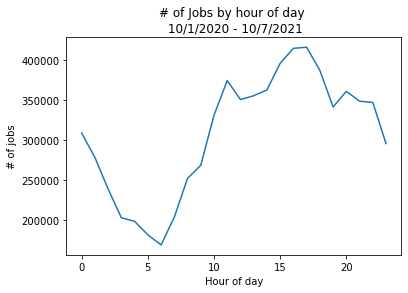

In [12]:
tmp_series = group_data(dataframe=jobs_ended.query("exitcode == '0:0'"), groupby='hour_of_day_end', agg='jobs_ended_per_hour')

draw_plot(series=tmp_series,
          title='# of Jobs by hour of day \n 10/1/2020 - 10/7/2021',
          xlabel='Hour of day',
          ylabel='# of jobs')

print_outliers_msg(series=tmp_series, label='hours of the day')


The top 5 busiest weeks were: [43 31 35 37 32]
The least busiest weeks were: [21 20 52  6 45]


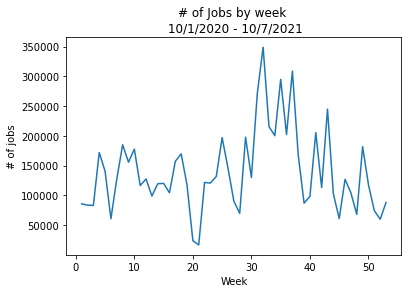

In [13]:
tmp_series = group_data(dataframe=jobs_ended, groupby='week_end', agg='jobs_ended_per_hour')
draw_plot(series=tmp_series,
          title='# of Jobs by week \n 10/1/2020 - 10/7/2021',
          xlabel='Week',
          ylabel='# of jobs')

print_outliers_msg(series=tmp_series, label='weeks')


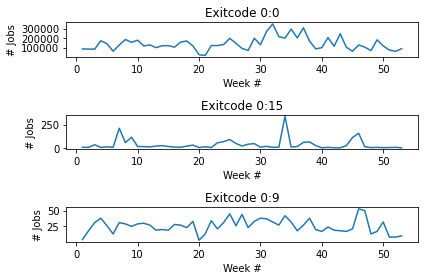

In [14]:
# trying to chart the different status types...

fig, axes = plt.subplots(nrows=3, ncols=1)

tmp_series = group_data_v2(dataframe=jobs_ended, groupby='week_end', agg='jobs_ended_per_hour')

i = 0
for column in tmp_series.columns.to_list():
    axes[i].set_title(f'Exitcode {column}')
    axes[i].set_ylabel('# Jobs')
    axes[i].set_xlabel('Week #')
    axes[i].plot(tmp_series[column])
    i+=1

plt.tight_layout()

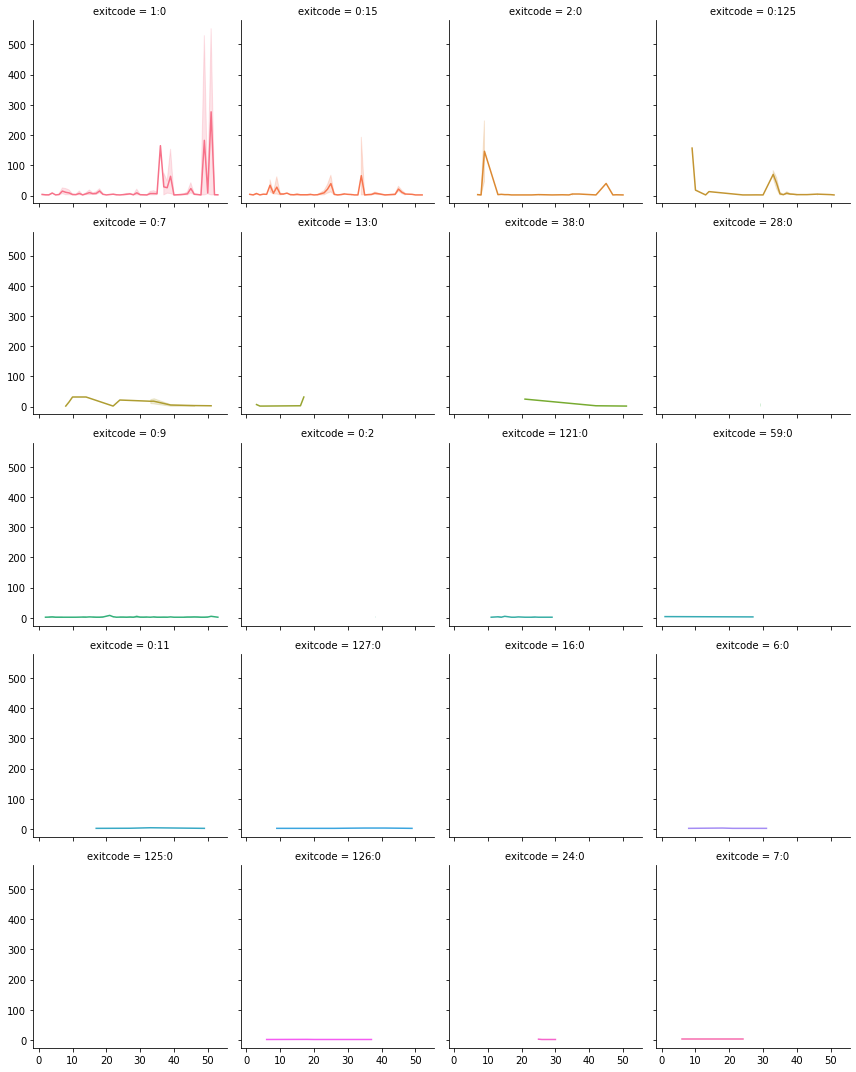

In [15]:
tmp = jobs_ended.reset_index().dropna()

g = sns.FacetGrid(tmp.query('exitcode != "0:0" and jobs_ended_per_hour > 1'),
                  col='exitcode',
                  col_wrap=4,
                  hue='exitcode')

g.map_dataframe(sns.lineplot, y='jobs_ended_per_hour', x='week_end')

The top 5 busiest months were: [ 6  3 10  9  8]
The least busiest months were: [11  5 12  1  4]


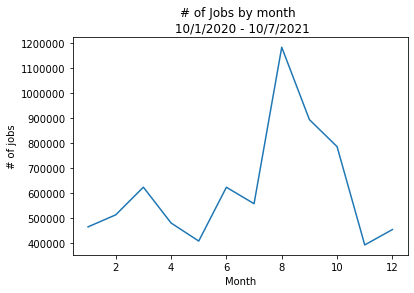

In [16]:
tmp_series = group_data(dataframe=jobs_ended, groupby='month_end', agg='jobs_ended_per_hour')

draw_plot(series=tmp_series,
          title='# of Jobs by month \n 10/1/2020 - 10/7/2021',
          xlabel='Month',
          ylabel='# of jobs')

print_outliers_msg(series=tmp_series, label='months')

In [17]:
jobs_ended.describe()

,day_end,jobs_ended_per_hour
count,12270.000000,12270.000000
mean,15.490057,602.708557
std,8.851637,1077.217252
min,1.000000,1.000000
25%,8.000000,4.000000
50%,15.000000,302.000000
75%,23.000000,703.000000
max,31.000000,13346.000000


<AxesSubplot:xlabel='month_end'>

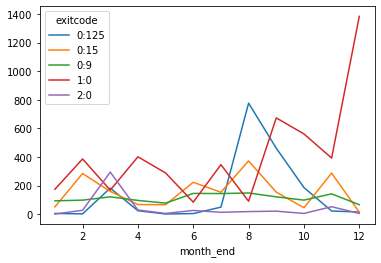

In [18]:
jobs_ended.query('exitcode != "0:0"').groupby(['exitcode', 'month_end'])['jobs_ended_per_hour'].agg('sum').unstack().dropna().transpose().plot()

    #.unstack().transpose().plot()


In [19]:
def build_plot(df, time_intervals, index_col='date_end', agg_col='jobs_ended_per_hour'):
    tmp_df = pd.DataFrame()
    for interval in time_intervals:
        data = df.reset_index().set_index(index_col).resample(interval)[agg_col].sum().reset_index()
        data['week_day'] = interval.split('-')[-1]
        data['month_name'] = data['date_end'].dt.month_name()
        tmp_df = pd.concat([tmp_df, data])
    return tmp_df

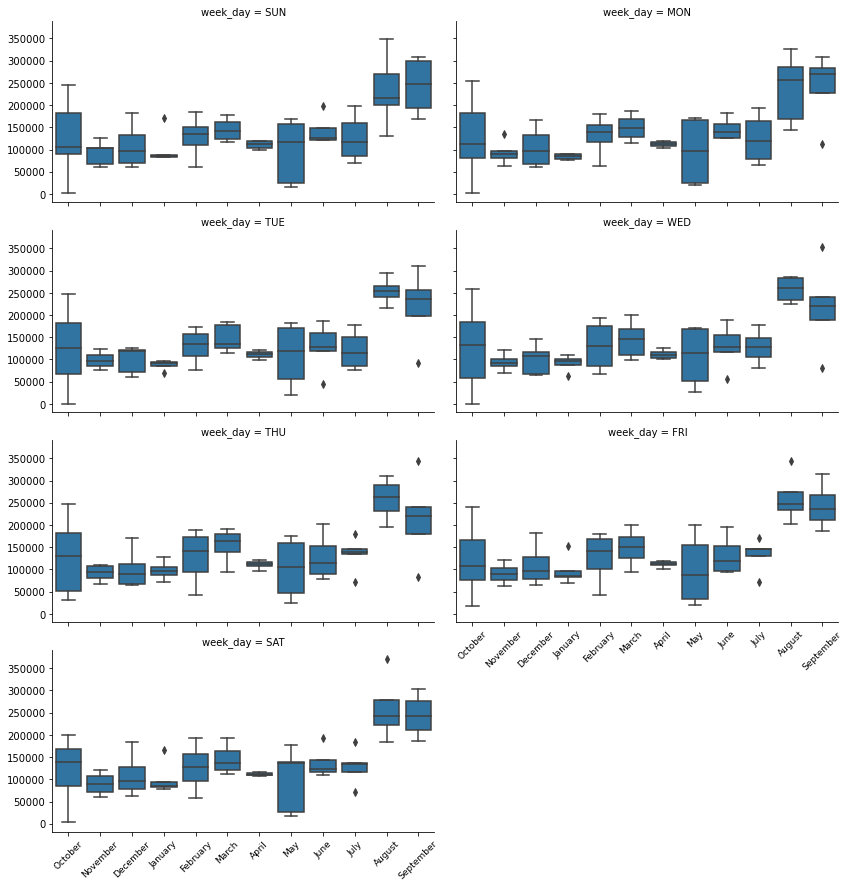

In [20]:
data = build_plot(jobs_ended, ['W-SUN', 'W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-FRI', 'W-SAT'])
g = sns.FacetGrid(data, col='week_day', col_wrap=2, aspect=2)
g.map_dataframe(sns.boxplot, y='jobs_ended_per_hour', x='month_name')

for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, fontsize=9)


In [21]:
jobs_ended.reset_index().groupby('day_name')['jobs_ended_per_hour'].sum()

day_name
FRI    1027294
MON    1120898
SAT     848092
SUN     882823
THU    1033677
TUE    1300031
WED    1182419
Name: jobs_ended_per_hour, dtype: int64

In [22]:
mod = ols('jobs_ended_per_hour ~ day_name', data=jobs_ended).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)


                sum_sq       df         F        PR(>F)
day_name  4.470408e+07      6.0  6.437878  8.678565e-07
Residual  1.419221e+10  12263.0       NaN           NaN


In [23]:
res = stat()
res.tukey_hsd(df=jobs_ended, res_var='jobs_ended_per_hour', xfac_var='day_name', anova_model='jobs_ended_per_hour ~ day_name')
res.tukey_summary




,group1,group2,Diff,Lower,Upper,q-value,p-value
0,FRI,WED,76.618629,-29.659778,182.897036,3.006396,0.337403
1,FRI,TUE,130.968277,25.094854,236.841701,5.158650,0.004951
2,FRI,MON,33.824500,-72.091793,139.740792,1.331759,0.900000
3,FRI,THU,37.623136,-67.204027,142.450299,1.496711,0.900000
4,FRI,SUN,26.142885,-83.511837,135.797606,0.994221,0.900000
5,FRI,SAT,40.502476,-69.556411,150.561363,1.534664,0.900000
6,WED,TUE,54.349649,-51.073808,159.773106,2.149891,0.705596
7,WED,MON,42.794129,-62.672380,148.260637,1.692102,0.895908
8,WED,THU,114.241765,9.869079,218.614450,4.564518,0.021347
9,WED,SUN,102.761513,-6.458820,211.981847,3.923592,0.081261


In [35]:
jobs_ended.reset_index().head()

,date_end,year_end,month_end,week_end,hour_of_day_end,day_end,month_name,day_name,exitcode,jobs_ended_per_hour
0,2020-12-11,2020.0,12.0,50.0,9.0,11.0,December,FRI,0:0,13346
1,2021-08-11,2021.0,8.0,32.0,16.0,11.0,August,WED,0:0,13046
2,2021-08-31,2021.0,8.0,35.0,16.0,31.0,August,TUE,0:0,12917
3,2021-09-01,2021.0,9.0,35.0,0.0,1.0,September,WED,0:0,12834
4,2021-09-13,2021.0,9.0,37.0,16.0,13.0,September,MON,0:0,12780


In [58]:
def build_days_df(df, col='day_name', val='jobs_ended_per_hour', days=None):
    if days is None:
	    days = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
    tmp_df = pd.DataFrame()
    for day in days:
        tmp_df[day] = df.query(f'{col} == "{day}"')[val]
    return tmp_df


days_df = build_days_df(jobs_ended.reset_index())

In [61]:
days_df = pd.DataFrame()
MON = jobs_ended.reset_index().query(f'day_name == "MON"')['jobs_ended_per_hour']
TUE = jobs_ended.reset_index().query(f'day_name == "TUE"')['jobs_ended_per_hour']
WED = jobs_ended.reset_index().query(f'day_name == "WED"')['jobs_ended_per_hour']
THU = jobs_ended.reset_index().query(f'day_name == "THU"')['jobs_ended_per_hour']
FRI = jobs_ended.reset_index().query(f'day_name == "FRI"')['jobs_ended_per_hour']
SAT = jobs_ended.reset_index().query(f'day_name == "SAT"')['jobs_ended_per_hour']
SUN = jobs_ended.reset_index().query(f'day_name == "SUN"')['jobs_ended_per_hour']


In [57]:
jobs_ended.reset_index().query(f'day_name == "WED"')['jobs_ended_per_hour'].shape

(1797,)

In [63]:
jobs_ended.groupby('day_name')['jobs_ended_per_hour'].describe()

,count,mean,std,min,25%,50%,75%,max
day_name,,,,,,,,
FRI,1767.0,581.377476,991.760665,1.0,3.00,300.0,728.00,13346.0
MON,1822.0,615.201976,1110.445208,1.0,2.00,287.5,702.50,12780.0
SAT,1568.0,540.875000,734.000118,1.0,117.75,313.0,653.00,7193.0
SUN,1590.0,555.234591,961.159776,1.0,91.00,260.0,612.75,8850.0
THU,1901.0,543.754340,906.414446,1.0,2.00,293.0,727.00,12320.0
TUE,1825.0,712.345753,1395.104482,1.0,2.00,331.0,758.00,12917.0
WED,1797.0,657.996105,1245.580894,1.0,3.00,336.0,712.00,13046.0


In [67]:
day_totals = jobs_ended.groupby(['date_end', 'day_name'])['jobs_ended_per_hour'].sum().reset_index()


In [68]:
fvalue, pvalue = stats.f_oneway(day_totals.query('day_name == "MON"')['jobs_ended_per_hour'],
                                day_totals.query('day_name == "TUE"')['jobs_ended_per_hour'],
                                day_totals.query('day_name == "WED"')['jobs_ended_per_hour'],
                                day_totals.query('day_name == "THU"')['jobs_ended_per_hour'],
                                day_totals.query('day_name == "FRI"')['jobs_ended_per_hour'],
                                day_totals.query('day_name == "SAT"')['jobs_ended_per_hour'],
                                day_totals.query('day_name == "SUN"')['jobs_ended_per_hour'],
                                )
print(fvalue, pvalue)


2.042002501696962 0.05941754589118867


In [70]:
day_totals.groupby(['day_name'])['jobs_ended_per_hour'].describe()


,count,mean,std,min,25%,50%,75%,max
day_name,,,,,,,,
FRI,53.0,19382.905660,11795.593876,194.0,10553.00,17585.0,25505.0,52078.0
MON,53.0,21149.018868,17449.981654,565.0,10852.00,15658.0,25093.0,102732.0
SAT,53.0,16001.735849,10181.584266,1867.0,9004.00,12936.0,18235.0,49955.0
SUN,53.0,16657.037736,15837.732096,1901.0,7365.00,12484.0,21820.0,104462.0
THU,54.0,19142.166667,11137.933630,331.0,10370.75,19876.0,25445.0,60093.0
TUE,53.0,24528.886792,21499.613486,222.0,12509.00,18133.0,27509.0,109988.0
WED,53.0,22309.792453,17147.471421,281.0,11636.00,18404.0,23805.0,91468.0


In [ ]:
jobs_ended.reset_index().info()

In [64]:
jobs_ended.head()


,,,,,day_end,month_name,day_name,exitcode,jobs_ended_per_hour
date_end,year_end,month_end,week_end,hour_of_day_end,,,,,
2020-12-11,2020.0,12.0,50.0,9.0,11.0,December,FRI,0:0,13346
2021-08-11,2021.0,8.0,32.0,16.0,11.0,August,WED,0:0,13046
2021-08-31,2021.0,8.0,35.0,16.0,31.0,August,TUE,0:0,12917
2021-09-01,2021.0,9.0,35.0,0.0,1.0,September,WED,0:0,12834
2021-09-13,2021.0,9.0,37.0,16.0,13.0,September,MON,0:0,12780


In [80]:
day_totals.head()

,date_end,day_name,jobs_ended_per_hour
0,2020-10-01,THU,33281
1,2020-10-02,FRI,30375
2,2020-10-03,SAT,15368
3,2020-10-04,SUN,17581
4,2020-10-05,MON,24166


(0.0, 60.0)

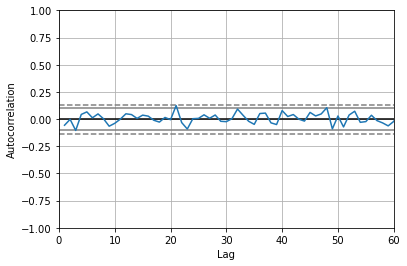

In [81]:
autocorrelation_plot(day_totals.sort_values(by='day_name')['jobs_ended_per_hour'])
plt.xlim(0,60)

(0.0, 24.0)

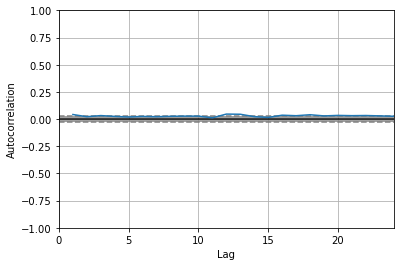

In [86]:
hour_totals = jobs_ended.groupby(['date_end', 'hour_of_day_end'])['jobs_ended_per_hour'].sum().reset_index()
hour_totals.head()

autocorrelation_plot(hour_totals.sort_values(by='hour_of_day_end')['jobs_ended_per_hour'])
plt.xlim(0,24)

In [93]:
# df.head()
# df.dropna(subset=['end']).sort_values(by='end').rolling('30d', on='end')

Rolling [window=2592000000000000,min_periods=1,center=False,win_type=freq,axis=0,on=end]

In [100]:
### Attempting 30 day rolling window...

trend30 = day_totals.rolling(14, center=True)['jobs_ended_per_hour'].mean()
trend30.head(30)


0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7     25137.357143
8     24484.071429
9     23819.500000
10    23570.214286
11    22767.285714
12    22056.357143
13    21944.571429
14    21341.428571
15    21353.857143
16    20108.000000
17    20456.785714
18    25581.642857
19    25600.357143
20    25546.571429
21    26060.642857
22    25320.642857
23    24912.142857
24    24737.714286
25    24831.142857
26    24469.142857
27    23829.285714
28    23442.857143
29    22477.928571
Name: jobs_ended_per_hour, dtype: float64

<AxesSubplot:>

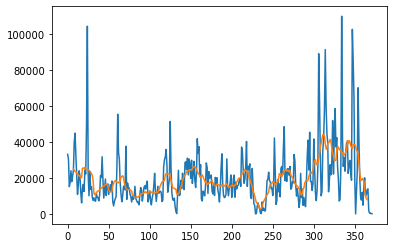

In [101]:
day_totals['jobs_ended_per_hour'].plot()
trend30.plot()


<AxesSubplot:>

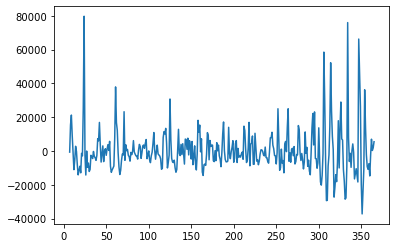

In [103]:
residual = day_totals['jobs_ended_per_hour'] - trend30
residual.plot()


(0.0, 30.0)

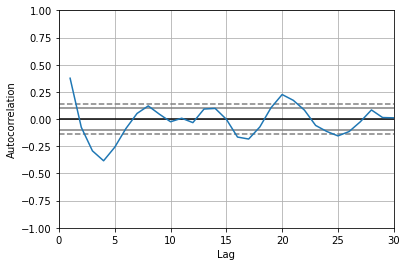

In [109]:
autocorrelation_plot(residual.dropna())
plt.xlim(0, 30)